2024-11-24 13:45:34.673607: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 13:45:35.654414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 13:46:06.788995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 912s 536ms/step - loss: 0.5723 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0746 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0461 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0404 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0307 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0215 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0148 - learning_rate: 0.0010
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch

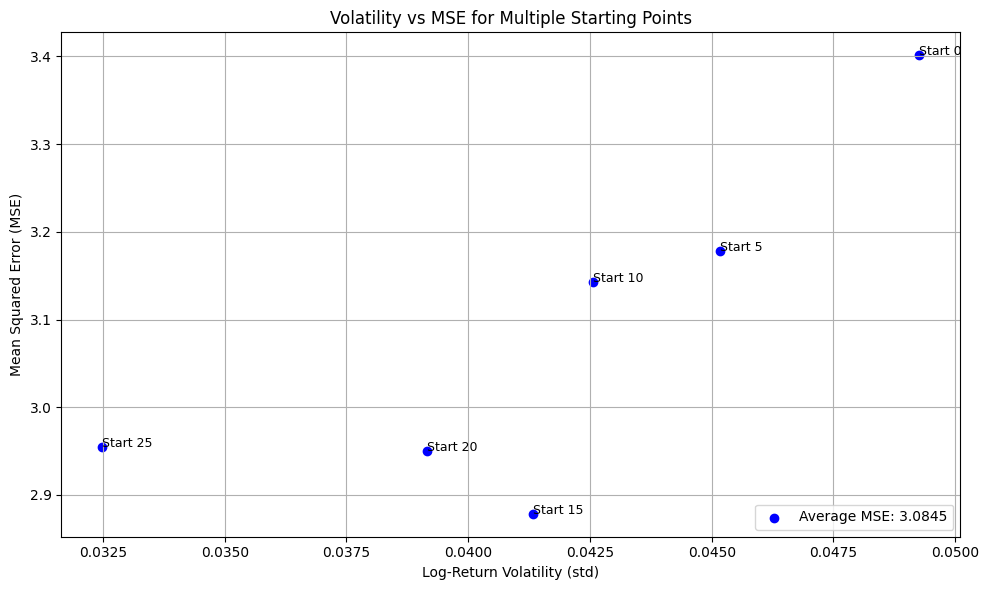

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset into training and testing sets
def split_data(df, training_period, train_ratio=0.8):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()

    # Split data into training and testing sets
    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    # Separate features and targets for train and test
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']
    # print("X_train",X_train[:3])
    # print("X_test",X_test[:3])
    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

def calculate_log_volatility(y_values):
    log_returns = np.log(y_values[1:] / y_values[:-1])  # Logarithmic returns
    return np.std(log_returns)  # Volatility as standard deviation of log returns

# Function to train the LSTM model with ReduceLROnPlateau scheduler
def train_lstm(X_train, y_train, input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))  # Add GRU layer
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Reshape input data for LSTM
    X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Reduce learning rate on plateau callback
    lr_scheduler = ReduceLROnPlateau(
        monitor='loss',          # Metric to monitor (use 'val_loss' if you have validation data)
        factor=0.5,              # Factor by which to reduce the learning rate (new_lr = lr * factor)
        patience=5,              # Number of epochs with no improvement before reducing learning rate
        verbose=1,               # Print messages when reducing the learning rate
        min_lr=1e-6              # Minimum learning rate
    )

    # Train the model with the learning rate scheduler
    model.fit(
        X_train, y_train.values,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[lr_scheduler]  # Add the ReduceLROnPlateau scheduler
    )
    return model


# Function to evaluate and visualize predictions for multiple starting points
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler):
    errors = []
    volatilities = []

    start_indices = range(0, 30, 5)  # Manually specify starting indices
    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict

        # Ensure the model always gets the past 15 days of data
        context_idx = start_idx - 30
        X_context = X_test.iloc[context_idx:start_idx]  # Past 15 days
        X_sub = X_test.iloc[start_idx:end_idx]
        y_true = y_test.iloc[start_idx:end_idx]

        # Reshape for LSTM input
        X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1], 1))
        print("xs",X_sub.shape)
        # Predict and invert scaling for the target
        predictions = model.predict(X_sub)
        print(predictions.shape)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        y_true_unscaled = target_scaler.inverse_transform(y_true.values.reshape(-1, 1)).ravel()

        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(y_true_unscaled, predictions))
        errors.append(rmse)

        # Calculate log-return volatility
        log_volatility = calculate_log_volatility(y_true_unscaled)
        volatilities.append(log_volatility)

        # Plot predictions
        plt.figure(figsize=(10, 6))
        plt.plot(test_index[start_idx:end_idx], y_true_unscaled, label="True Data", color="green")
        plt.plot(test_index[start_idx:end_idx], predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("../TSLA_pred/lstm", exist_ok=True)
        plt.savefig(f"../TSLA_pred/lstm/start_{start_idx}.png")
        plt.close()

    # Calculate average MSE
    avg_mse = np.mean(errors)

    # Scatter plot: log-return volatility vs MSE
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, errors, marker="o", color="blue")
    for i, idx in enumerate(start_indices):
        plt.text(volatilities[i], errors[i], f"Start {idx}", fontsize=9)
    plt.xlabel("Log-Return Volatility (std)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Volatility vs MSE for Multiple Starting Points")
    plt.grid(True)

    # Add legend with average MSE
    plt.legend([f"Average MSE: {avg_mse:.4f}"], loc="lower right")
    plt.tight_layout()

    # Save the plot
    os.makedirs("../TSLA_pred/lstm", exist_ok=True)
    plt.savefig("../TSLA_pred/lstm/log_volatility_vs_mse.png")
    plt.show()
# Main function
# def main():
training_period = 30  # Number of days for lag features
n_days_to_predict = 30  # Number of days to predict for each starting point
num_start_points = 30  # Number of unique starting points
path = "../TSLA.csv"  # Path to your stock data file

# Load and preprocess data
headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
df = pd.read_csv(path, names=headers, skiprows=1)
df.replace("null", np.nan, inplace=True)
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
df.set_index("Date", inplace=True)

# Split the dataset into training and testing sets
X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)

# Train the LSTM model
input_shape = (X_train.shape[1], 1)  # Number of features as input shape
model = train_lstm(X_train, y_train, input_shape)

# Evaluate predictions for multiple starting points
evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler)

# Run the main function
# if __name__ == "__main__":
# main()
